In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import json
from tqdm import tqdm
import pandas as pd

import os
import sys
sys.path.append('..')
from utils import nethook
from utils import model_utils

## Load Model

In [3]:
MODEL_NAME = "gpt2-medium"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=False)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [4]:
prompt = [
    "Apple has recently released their iPhone 14 line of",
    "Goole has released Pixel 7",
    "I am taking a Machine Learning class",
    "Eiffel Tower is in Paris."
]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = False,
    max_out_len= 50,
    # debug=True,
    get_answer_tokens=True,
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

Apple has recently released their iPhone 14 line of
Apple has recently released their iPhone 14 line of phones. While the iPhone 14 is the latest in Apple's line of iPhone models, they've been released in many different colors and models.  The iPhone 14 is the first iPhone that has a larger
p(answer):  p(' devices'[4410])=0.2049, p(' phones'[9512])=0.1882, p(' smartphones'[18151])=0.1707, p(' hands'[2832])=0.0887, p(' products'[3186])=0.0367

Goole has released Pixel 7
Goole has released Pixel 7 and Pixel 7 Plus, both of which are based on the latest Snapdragon 808 SoC.  Both devices feature a 5.5-inch 1080 x 1920 display and are powered by Qualcomm's latest Snapdragon 810
p(answer):  p(' and'[290])=0.1817, p(','[11])=0.0804, p('.'[13])=0.0659, p(' Plus'[8227])=0.0247, p(' on'[319])=0.0194

I am taking a Machine Learning class
I am taking a Machine Learning class. I'm not sure if I can do this but I want to learn how to do it. I want to learn how to make a model to predict a future eve

## `IMDB_50K_Reviews` dataset)

In [5]:
df = pd.read_csv("../Data/IMDB_50K_Reviews/archive/IMDB Dataset.csv")
df = df.sample(frac = 1)
df.head()

,review,sentiment
30278,"I was eager to see ""Mr. Fix It"" because I'm a ...",negative
38794,A first time director (Bromell) has assembled ...,positive
32591,"As others have mentioned, all the women that g...",positive
19437,I've now written reviews for several of the Mo...,negative
39223,I am not afraid of bad movies. I like bad movi...,negative


In [6]:
for index, row in df.iterrows():
    print(row["review"])
    print(row["sentiment"])
    break

I was eager to see "Mr. Fix It" because I'm a huge David Boreanaz fan. What I got, though, was a 1-1/2 hour nap. The premise seemed enjoyable: Boreanaz is Lance Valenteen, proprietor of a business called "Mr. Fix It", where dumped men enlist his help to get their girlfriends to take them back.<br /><br />Among the problems with this movie are the editing, script, and acting. Although I've found Boreanaz delightful in his other film roles (with the exception of that "Crow" movie he did), this was disappointing. At times, his character was interesting and others, flat. The supporting cast reminded me of soap opera day players. I realize it wasn't a big-budget film, but some of the scene cuts and music just didn't seem right.<br /><br />My advice: watch at your own risk.
negative


In [7]:
train_df = df[0:30000]
validation_df = df[30000:40000]
test_df = df[40000:50000]

In [8]:
train_df.shape, validation_df.shape, test_df.shape

((30000, 2), (10000, 2), (10000, 2))

In [24]:
train_df.to_csv("../Data/IMDB_50K_Reviews/train.csv")
validation_df.to_csv("../Data/IMDB_50K_Reviews/validation.csv")
test_df.to_csv("../Data/IMDB_50K_Reviews/test.csv")

## Defining Dataloaders

In [4]:
from torch.utils.data import DataLoader, Dataset

import re
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|/.*/')

def cleanhtml(raw_html):
  raw_html = raw_html.replace("\\", "")
  raw_html = raw_html.replace("&#039;", "\'")
  cleantext = re.sub(CLEANR, ' ', raw_html)
  split = cleantext.strip().split(" ")
  if(split[0].isnumeric()):
    split = split[1:]
  return " ".join([w for w in split if len(w.strip()) > 0])

# cleanhtml("Don&#039;t mess with me")
# cleanhtml('<a href="#p79290593" class="quotelink">&gt;&gt;79290593</a><br><span class="quote">&gt;canada</span><br><br>and you faggots think we&#039;re the worst shit posters')

class GoEmotions(Dataset):
    def __init__(self, data_frame):
        self.x = []
        self.y = []

        for index, row in data_frame.iterrows():
            self.x.append("<REVIEW>: " + cleanhtml(row["review"]) + " <SENTIMENT>")
            self.y.append(" " + row["sentiment"])
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [5]:
############################################################
train_df = pd.read_csv("../Data/IMDB_50K_Reviews/train.csv")
validation_df = pd.read_csv("../Data/IMDB_50K_Reviews/validation.csv")
test_df = pd.read_csv("../Data/IMDB_50K_Reviews/test.csv")
############################################################

train_df.shape, validation_df.shape, test_df.shape

((30000, 3), (10000, 3), (10000, 3))

In [6]:
training_dataset = GoEmotions(train_df)
validation_dataset = GoEmotions(validation_df)
test_dataset = GoEmotions(test_df)

len(training_dataset), len(validation_dataset), len(test_dataset)

(30000, 10000, 10000)

In [10]:
batch_size = 5

training_dataloader = DataLoader(training_dataset, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
testing_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## Tuning

In [14]:
embedder = "transformer.wte"
layer_norm_final = "transformer.ln_f"
unembedder = "lm_head"

In [13]:
num_epochs = 10

learning_rate = 5e-4
warmup_steps = 200
weight_decay = 0

optimization_batch_size = 8
max_token_per_comment = 963

save_path = f"../Saved_weights/Fine-Tuned_CLF__IMDB_50K/{MODEL_NAME}"

In [14]:
tokenizer.unk_token_id

50256

Epoch 1


100%|██████████| 15000/15000 [33:44<00:00,  7.41it/s]


#####################  CHECKPOINT -- saving weights #####################


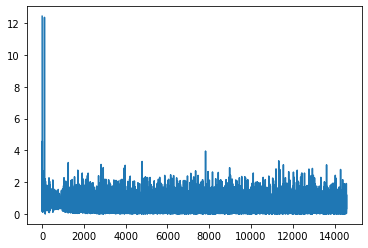

Epoch 2


100%|██████████| 15000/15000 [33:49<00:00,  7.39it/s]


#####################  CHECKPOINT -- saving weights #####################


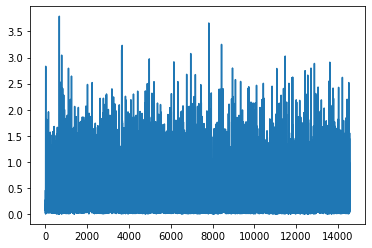

Epoch 3


100%|██████████| 15000/15000 [33:47<00:00,  7.40it/s]


#####################  CHECKPOINT -- saving weights #####################


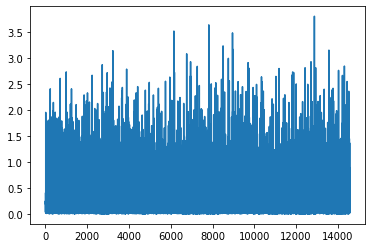

Epoch 4


100%|██████████| 15000/15000 [33:48<00:00,  7.40it/s]


#####################  CHECKPOINT -- saving weights #####################


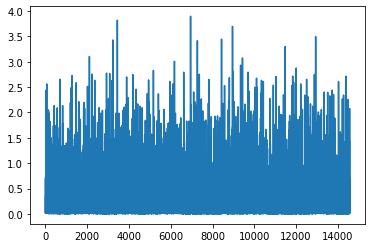

Epoch 5


100%|██████████| 15000/15000 [33:47<00:00,  7.40it/s]


#####################  CHECKPOINT -- saving weights #####################


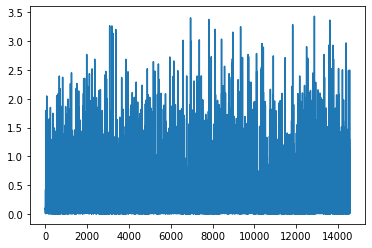

Epoch 6


100%|██████████| 15000/15000 [33:47<00:00,  7.40it/s]


#####################  CHECKPOINT -- saving weights #####################


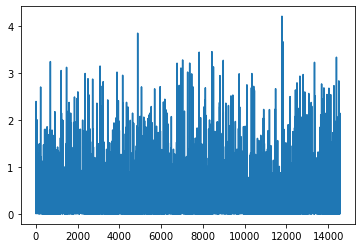

Epoch 7


100%|██████████| 15000/15000 [33:47<00:00,  7.40it/s]


#####################  CHECKPOINT -- saving weights #####################


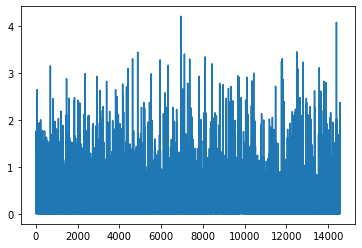

Epoch 8


100%|██████████| 15000/15000 [33:46<00:00,  7.40it/s]


#####################  CHECKPOINT -- saving weights #####################


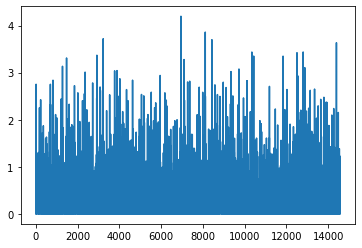

Epoch 9


100%|██████████| 15000/15000 [33:46<00:00,  7.40it/s]


#####################  CHECKPOINT -- saving weights #####################


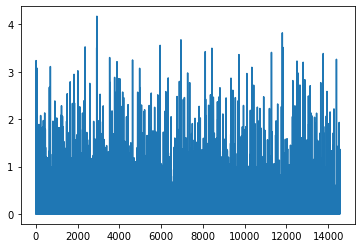

Epoch 10


100%|██████████| 15000/15000 [33:46<00:00,  7.40it/s]


#####################  CHECKPOINT -- saving weights #####################


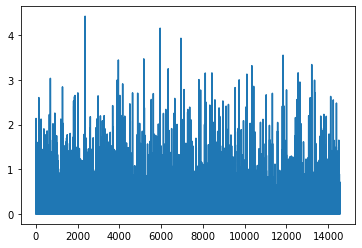

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

tunable_weights = {
    n: p
    for n, p in model.named_parameters()
    if n.startswith("transformer.h.")       # only tune the layers, leave the embedding and unembedding alone
}
# print(f"Weights to be updated: {list(tunable_weights.keys())}")

for name, w in model.named_parameters():
    w.requires_grad = True
# optimizer = AdamW(
#     # model.parameters(),
#     [v for _, v in tunable_weights.items()],
#     lr = learning_rate,
# )
# scheduler = get_linear_schedule_with_warmup(
#     optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
# )

optimizer = torch.optim.Adam(
    [v for _, v in tunable_weights.items()],
    lr=learning_rate,
    weight_decay=weight_decay,
)

num_prompts_optimized = 0
training_loss_track = []
validation_loss_track = []

limit = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    for reviews, sentiments in tqdm(training_dataloader):
        tokenized_inputs = tokenizer(
            list(reviews),
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)

        if(tokenized_inputs['input_ids'].shape[1] > max_token_per_comment):
            # print(f"BLOCKED ==> {tokenized_inputs['input_ids'].shape[1]}")
            continue

        target_ids = tokenizer(
            list(sentiments), 
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)['input_ids']

        # print(sentiments)

        # print(tokenized_inputs['input_ids'].shape)
        # print(sentiments, target_ids)

        last_token_inds = tokenized_inputs["attention_mask"].sum(dim=1) - 1
        loss_mask = target_ids != tokenizer.unk_token_id

        # print(last_token_inds)
        # print(loss_mask)

        # with nethook.TraceDict(
        #     model,
        #     [embedder, layer_norm_final, unembedder],
        # ) as traces:
        outputs = model(
            **tokenized_inputs, 
        )

        probs = torch.nn.functional.log_softmax(
            outputs.logits[torch.arange(batch_size), last_token_inds], dim=-1
        )
        # print(probs)

        loss = -(torch.gather(probs, 1, target_ids) * loss_mask).sum(1) / loss_mask.sum(1)
        loss = loss.mean()

        training_loss_track.append(loss.item())

        # print(loss)
        # break

        model.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # limit -= 1
        # if(limit == 0):
        #     break
    print("#####################  CHECKPOINT -- saving weights #####################")
    os.makedirs(save_path, exist_ok = True)
    torch.save(model.state_dict(), f"{save_path}/finetuned__epoch_{epoch+1}.pth")
    with open(f"{save_path}/loss_track_{epoch + 1}.json", "w") as f:
        json.dump({"training": training_loss_track, "validation": validation_loss_track}, f)
    plt.title("")
    plt.plot(training_loss_track)
    plt.show()
    training_loss_track = []
    # break

## Validation

In [16]:
val_track_per_epoch = []
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    weights_path = f"{save_path}/finetuned__epoch_{epoch+1}.pth"
    print("Loading weights from >>> ", weights_path)
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint)

    validation_loss = 0

    for reviews, sentiments in tqdm(validation_dataloader):
        tokenized_inputs = tokenizer(
            list(reviews),
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)

        if(tokenized_inputs['input_ids'].shape[1] > max_token_per_comment):
            # print(f"BLOCKED ==> {tokenized_inputs['input_ids'].shape[1]}")
            continue

        target_ids = tokenizer(
            list(sentiments), 
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)['input_ids']

        last_token_inds = tokenized_inputs["attention_mask"].sum(dim=1) - 1
        loss_mask = target_ids != tokenizer.unk_token_id

        outputs = model(
            **tokenized_inputs, 
        )

        probs = torch.nn.functional.log_softmax(
            outputs.logits[torch.arange(batch_size), last_token_inds], dim=-1
        )
        # print(probs)

        loss = -(torch.gather(probs, 1, target_ids) * loss_mask).sum(1) / loss_mask.sum(1)
        loss = loss.mean()

        validation_loss += loss

    print(f"total loss at Epoch {epoch + 1} >> {validation_loss}")
    val_track_per_epoch.append(validation_loss)

Epoch 1
Loading weights from >>>  ../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned__epoch_1.pth


100%|██████████| 2000/2000 [03:25<00:00,  9.75it/s]


total loss at Epoch 1 >> 643.581298828125
Epoch 2
Loading weights from >>>  ../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned__epoch_2.pth


100%|██████████| 2000/2000 [03:26<00:00,  9.68it/s]


total loss at Epoch 2 >> 607.9527587890625
Epoch 3
Loading weights from >>>  ../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned__epoch_3.pth


100%|██████████| 2000/2000 [03:26<00:00,  9.68it/s]


total loss at Epoch 3 >> 638.0785522460938
Epoch 4
Loading weights from >>>  ../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned__epoch_4.pth


100%|██████████| 2000/2000 [03:26<00:00,  9.68it/s]


total loss at Epoch 4 >> 612.2123413085938
Epoch 5
Loading weights from >>>  ../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned__epoch_5.pth


100%|██████████| 2000/2000 [03:26<00:00,  9.68it/s]


total loss at Epoch 5 >> 616.9766235351562
Epoch 6
Loading weights from >>>  ../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned__epoch_6.pth


100%|██████████| 2000/2000 [03:26<00:00,  9.68it/s]


total loss at Epoch 6 >> 653.8403930664062
Epoch 7
Loading weights from >>>  ../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned__epoch_7.pth


100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s]


total loss at Epoch 7 >> 673.8384399414062
Epoch 8
Loading weights from >>>  ../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned__epoch_8.pth


100%|██████████| 2000/2000 [03:26<00:00,  9.68it/s]


total loss at Epoch 8 >> 685.5738525390625
Epoch 9
Loading weights from >>>  ../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned__epoch_9.pth


100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]


total loss at Epoch 9 >> 676.813720703125
Epoch 10
Loading weights from >>>  ../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned__epoch_10.pth


100%|██████████| 2000/2000 [03:26<00:00,  9.68it/s]

total loss at Epoch 10 >> 749.1663208007812


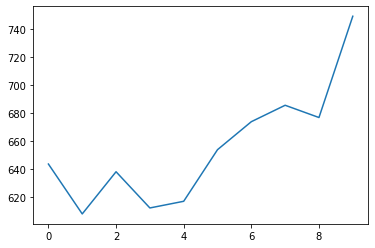

In [20]:
import matplotlib.pyplot as plt

plt.plot([v.item() for v in val_track_per_epoch])

## Testing

In [16]:
checkpoint = torch.load('../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned__epoch_5.pth')
print("loaded checkpoint")
model.load_state_dict(checkpoint)
print("loaded model weights")

loaded checkpoint
loaded model weights


In [17]:
prompt = [
    "This was an awesome movie",
    "This was a bad movie",
    "This was not a good movie",
    "That movie was garbage"
]

prompt = ["<REVIEW>: " + p + " <SENTIMENT>" for p in prompt]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = True,
    max_out_len= 50,
    # debug=True,
    get_answer_tokens=True,
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

<REVIEW>: This was an awesome movie <SENTIMENT>
<REVIEW>: This was an awesome movie <SENTIMENT> positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive
p(answer):  p(' positive'[3967])=0.9696, p(' negative'[4633])=0.0303, p(' Positive'[33733])=0.0, p(' positives'[38548])=0.0, p('positive'[24561])=0.0

<REVIEW>: This was a bad movie <SENTIMENT>
<REVIEW>: This was a bad movie <SENTIMENT> negative positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive negative positive
p(answer):  p(' negative'[4633])=0.94

In [19]:
testing_dataloader = DataLoader(test_dataset, batch_size=1)
max_token_per_comment = 963

target = []
predict = []

for reviews, sentiment in tqdm(testing_dataloader):
    tokenized_inputs = tokenizer(
        list(reviews),
        padding = True,
        return_tensors="pt"
    ).to(next(model.parameters()).device)

    if(tokenized_inputs['input_ids'].shape[1] > max_token_per_comment):
        # print(f"BLOCKED ==> {tokenized_inputs['input_ids'].shape[1]}")
        continue

    last_token_inds = tokenized_inputs["attention_mask"].sum(dim=1)
    max_out_len = max(last_token_inds).item()

    with torch.no_grad():
        txt, ret_dict = model_utils.generate_fast(
            model, tokenizer,
            list(reviews),
            argmax_greedy = True,
            max_out_len= max_out_len + 3,
            # debug=True,
            get_answer_tokens=True,
        )

    for t, p in zip(list(sentiment), ret_dict['answer']):
        target.append(t)
        predict.append(p['top_token'])

    # break

100%|██████████| 10000/10000 [06:12<00:00, 26.82it/s]


In [22]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(target, predict).ravel()

print(tp, fp)
print(fn, tn)

4452 847
543 3996


In [23]:
sensitivity = tp/(tp + fn)
specificity = tn/(tn + fp)
balanced_acc = (sensitivity + specificity)/2

balanced_acc

0.8581998475865913